<a href="https://colab.research.google.com/github/gzmlab/Forecasting-Time-Series-Data-with-Prophet-Second-Edition/blob/main/Chapter01/Chapter_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1: The History and Development of Time Series Forecasting

## Understanding time series forecasting

### The problem with dependent data

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.interpolate import make_interp_spline

In [34]:
# Raw URL of the dataset
url = "https://raw.githubusercontent.com/gzmlab/Forecasting-Time-Series-Data-with-Prophet-Second-Edition/main/data/spurious_correlations.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows of the dataset
print(df.head())

   Year  Number of films Nicolas Cage appeared in  \
0  1999                                         2   
1  2000                                         2   
2  2001                                         2   
3  2002                                         3   
4  2003                                         1   

   Number people who drowned by falling into a swimming-pool  
0                                                109          
1                                                102          
2                                                102          
3                                                 98          
4                                                 85          


In [35]:
x_new = np.linspace(df['Year'].min(), df['Year'].max(), 300)
Nic_Cage_smooth = make_interp_spline(df['Year'],
                                     df['Number of films Nicolas Cage appeared in'],
                                     k=3,
                                     bc_type='natural')(x_new)

pool_drownings_smooth = make_interp_spline(df['Year'],
                                           df['Number people who drowned by falling into a swimming-pool'],
                                           k=3,
                                           bc_type='natural')(x_new)

df2 = pd.DataFrame({'Year': x_new,
                    'Number of films Nicolas Cage appeared in': Nic_Cage_smooth,
                    'Number people who drowned by falling into a swimming-pool': pool_drownings_smooth})

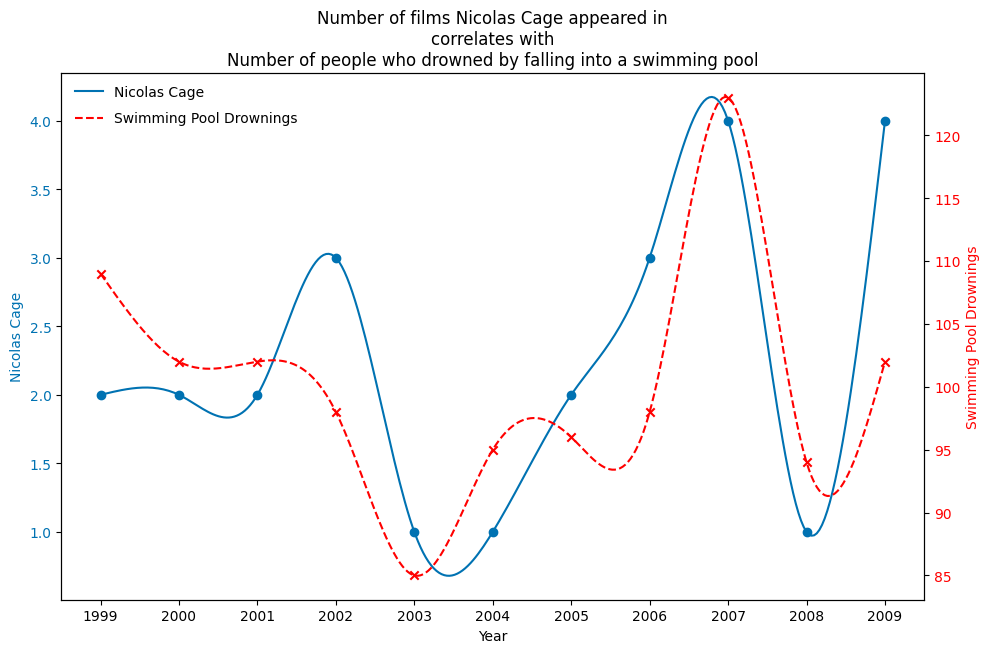

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 6))
color = '#0072B2'
ax1.set_xlabel('Year')
ax1.set_ylabel('Nicolas Cage', color=color)
ax1.plot(df2['Year'], df2['Number of films Nicolas Cage appeared in'], color=color, ls='-', label='Nicolas Cage')
ax1.scatter(df['Year'], df['Number of films Nicolas Cage appeared in'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=(0.01, .94), frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Swimming Pool Drownings', color=color)  # we already handled the x-label with ax1
ax2.plot(df2['Year'], df2['Number people who drowned by falling into a swimming-pool'], color=color, ls='--', label='Swimming Pool Drownings')
ax2.scatter(df['Year'], df['Number people who drowned by falling into a swimming-pool'], color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=(0.01, .89), frameon=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# The original title had invalid LaTeX syntax.
# Changed '\bfNumber' to '\\textbf{Number}' for bold text.
# Split the long title string for better readability.
plt.title(r'Number of films Nicolas Cage appeared in' +
          '\ncorrelates with\n' +
          r'Number of people who drowned by falling into a swimming pool')
plt.xticks(ticks=df['Year'].tolist(), labels=df['Year'].tolist())
plt.show()

### Moving average and exponential smoothing

In [37]:
# Raw URL of the dataset
url = "https://raw.githubusercontent.com/gzmlab/Forecasting-Time-Series-Data-with-Prophet-Second-Edition/main/data/instagram_natgeo.csv"

# Load the dataset into a pandas DataFrame
data = pd.read_csv(url)

# Display the first few rows of the dataset
print(data.head())

        Date  Average Likes Per Photo
0  3/24/2012              1043.000000
1  3/25/2012              1707.666667
2  3/26/2012              1300.142857
3  3/27/2012               785.666667
4  3/28/2012              1376.200000


In [38]:
# Convertir la colonne Date en datetime
data['date_converted'] = pd.to_datetime(data['Date'])

# Filtrer les données pour la période 2015
df = data[(data['date_converted'] >= '2015-01-01') & (data['date_converted'] < '2016-01-01')][['date_converted', 'Average Likes Per Photo']]

# Créer une nouvelle colonne date avant le groupby
df['date'] = df['date_converted'].dt.date

# Groupby avec la nouvelle colonne
df = df.groupby('date').mean().reset_index()

# Convertir les valeurs en milliers
df['likes'] = df['Average Likes Per Photo'] / 1000

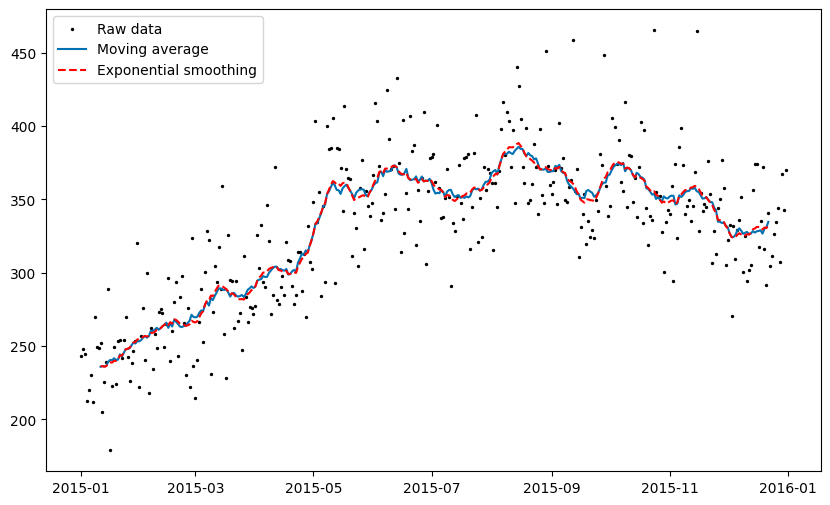

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(df['date_converted'], df['likes'], label='Raw data', c='k', s=2)
plt.plot(df['date_converted'],
         df['likes'].rolling(window=20, center=True).mean(),
         label='Moving average',
         ls='-',
         c='#0072B2')

plt.plot(df['date_converted'],
         df['likes'].rolling(window=20, center=True, win_type='exponential').mean(tau=10),
         label='Exponential smoothing',
         ls='--',
         c='r')
plt.legend()
plt.show()

### ARCH/GARCH

In [40]:
x = np.arange(0, 100, .5)
y1 = [25 + .5 * val + 7 * random.random() for val in x]
y2 = [.5 * val + 3 * (random.random() - .5) * val / 7 for val in x]

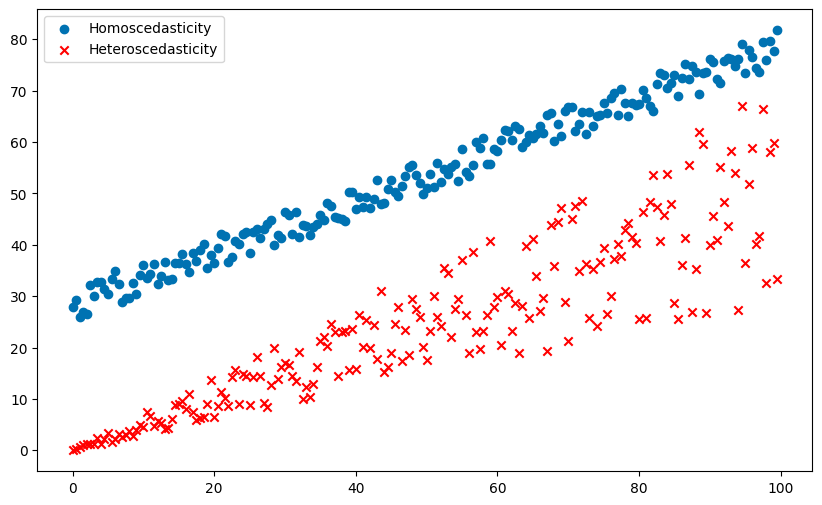

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y1, label='Homoscedasticity', marker='o', c='#0072B2')
plt.scatter(x, y2, label='Heteroscedasticity', marker='x', c='r')
plt.legend()
plt.show()

### Prophet

In [42]:
x = pd.date_range('2000-01-01', '2003-12-31', freq='H')
y0 = [1000 + .025 * val for val in range(len(x))]  # create trend curve
y1 = [50 * np.sin(idx * (360 / (365.25 * 24)) * (np.pi / 180)) for idx in range(len(y0))]  # add annual sinusoidal variation
y2 = [(25 * np.sin(((idx / 7) - 17) * (360 / 24) * (np.pi / 180))) +
      (10 * np.sin(((idx / 7) - 5) * (360 / 12) * (np.pi / 180))) +
      (25 * np.sin(((idx / 7) - 12) * (360 / 12) * (np.pi / 180))) +
      (15 * np.sin(((idx / 7) - 20) * (360 / 12) * (np.pi / 180)))
      for idx in range(len(x))]  # add weekly variation
y3 = [20 * np.sin((idx - 6) * (360 / 24) * (np.pi / 180)) for idx in range(len(y2))]  # add daily sinusoidal variation

# Create additive curves
z0 = y0
z1 = [y0[idx] + y1[idx] for idx in range(len(x))]
z2 = [y0[idx] + y1[idx] + y2[idx] for idx in range(len(x))]
z3 = [y0[idx] + y1[idx] + y2[idx] + y3[idx] for idx in range(len(x))]

<ipython-input-42-412a64a94645>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x = pd.date_range('2000-01-01', '2003-12-31', freq='H')


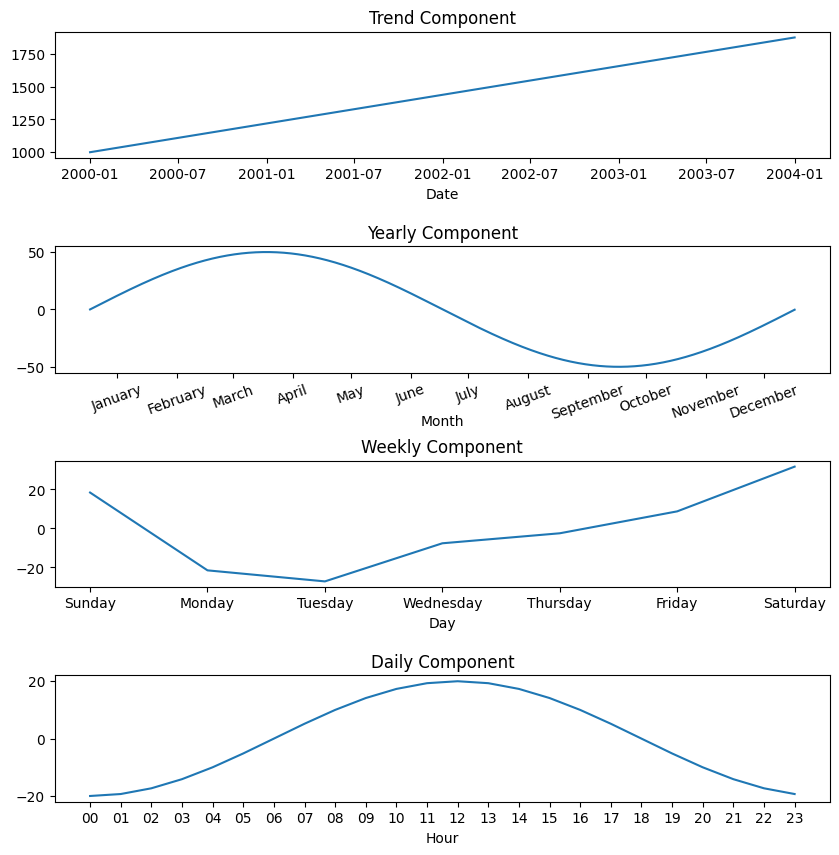

In [43]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=.7)

ax[0].set_title('Trend Component')
ax[0].plot(x, y0)
ax[0].set_xlabel('Date')
# ax[0].set_ylabel('Contribution to Sales')

ax[1].set_title('Yearly Component')
ax[1].plot(x[:24 * 365], y1[:24 * 365])
ax[1].set_xticks([ts for ts in x[:24 * 365] if ts.hour == 0 and ts.day == 15])
ax[1].set_xticklabels([ts.month_name() for ts in x[:24 * 365] if ts.hour == 0 and ts.day == 15], rotation=20)
ax[1].set_xlabel('Month', labelpad=-5)
# ax[1].set_ylabel('Contribution to Sales')

ax[2].set_title('Weekly Component')
ax[2].plot([ts.day_name() for ts in x[24: 24 * 8] if ts.hour == 12], [y2[idx] for idx in range(len(x[24: 24 * 8])) if x[idx].hour == 23])
ax[2].set_xlabel('Day')
# ax[2].set_ylabel('Contribution to Sales')

ax[3].set_title('Daily Component')
ax[3].plot(x[:24].strftime('%#H'), y3[:24])
ax[3].set_xlabel('Hour')
# ax[3].set_ylabel('Contribution to Sales')

plt.show()

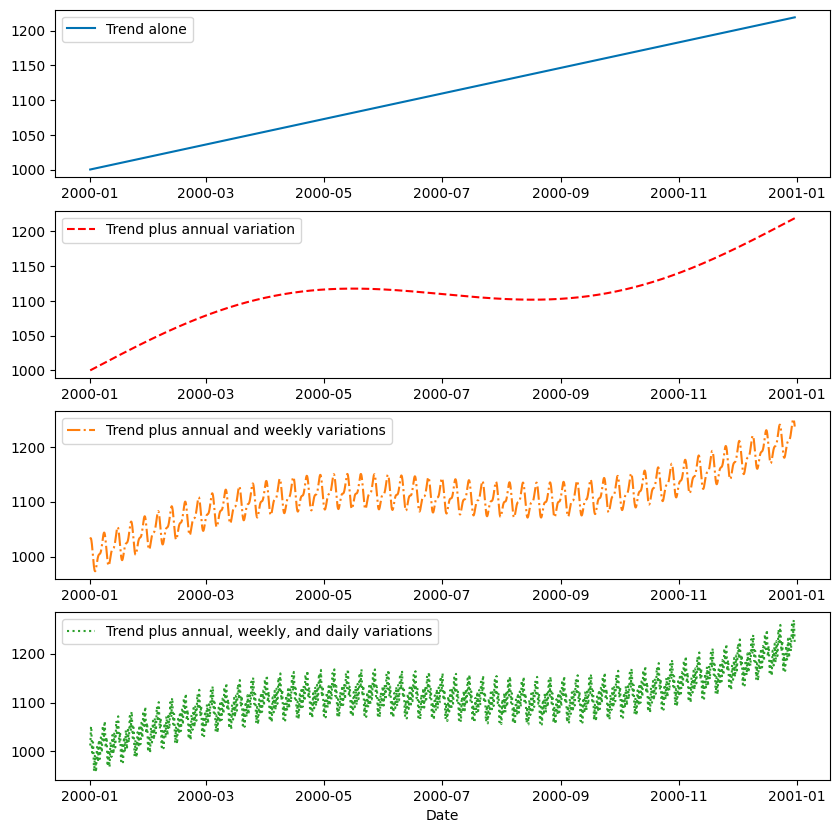

In [44]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

ax[0].plot(x[:8760], z0[:8760], label='Trend alone', c='#0072B2', ls='-')
ax[0].legend()

ax[1].plot(x[:8760], z1[:8760], label='Trend plus annual variation', c='r', ls='--')
ax[1].legend()

ax[2].plot(x[:8760], z2[:8760], label='Trend plus annual and weekly variations', c='tab:orange', ls='-.')
ax[2].legend()

ax[3].plot(x[:8760], z3[:8760], label='Trend plus annual, weekly, and daily variations', c='tab:green', ls=':')
ax[3].legend()
ax[3].set_xlabel('Date')

plt.show()